In [1]:
# load packages
import numpy as np
import sounddevice as sd
import soundfile as sf
import pyfar as pf
from scipy.io.wavfile import write
import matplotlib.pyplot as mp
from numpy.fft import rfft, irfft
from time import sleep

from numpy import ndarray

In [2]:
# check which audio input is selected
sd.default.device = 3
sd.query_devices()
# set audio input device

  0 Built-in Microphone, Core Audio (2 in, 0 out)
  1 Built-in Output, Core Audio (0 in, 2 out)
  2 rekordbox Aggregate Device, Core Audio (0 in, 2 out)
* 3 Babyface Pro (73019724), Core Audio (14 in, 14 out)

In [28]:
def convert_audio_to_numpy_array(recording_path: str):
    data, samplerate = sf.read(recording_path, dtype='float32')
    return data, samplerate
    
def record_sound(duration: int, samplerate: int, channel_count: int):
    return sd.rec(int(duration * samplerate), samplerate=samplerate, channels=channel_count)

def play_sound(recording: ndarray, samplerate: int):
    sd.play(recording, samplerate)

def play_and_record(recording, samplerate, channels):
    return sd.playrec(recording, samplerate, channels, dtype='float64')

In [34]:
# convert sweep wav file into ndarray
sweep, fs = convert_audio_to_numpy_array("../sounds/input/Sweep20_20k.wav")
# play audio
sd.play(sweep, fs)

In [35]:
sweep_rec = play_and_record(sweep, fs, 2)
sweep_rec.shape

(96480, 2)

### Deconvolution

In [36]:
def pad_array(recording):
    # define length of FFT (zero padding): at least double length of input
    input_length = np.size(recording)
    n = np.ceil(np.log2(input_length)) + 1
    N_fft = int(pow(2, n))
    N_single_sided = N_fft/2+1

    return input_length, N_fft, N_single_sided

In [37]:
def transform_t_to_f(audio, recording, N_fft):
    y_l = recording[:, 0] # left channel
    y_r = recording[:, 1] # right channel

    print(np.shape(recording))

    X_f = rfft(audio, N_fft)
    Yl_f = rfft(y_l, N_fft)
    Yr_f = rfft(y_r, N_fft)

    return y_l, y_r, X_f, Yl_f, Yr_f



In [38]:
def compute_filter(X_f, Yl_f, Yr_f):
    X_f_inv = 1 / X_f
    Hl_f = Yl_f * X_f_inv
    Hr_f = Yr_f * X_f_inv

    return Hl_f, Hr_f
    

In [39]:
def transform_f_to_t(Hl_f, Hr_f, N_fft, input_length):
    # backward transform
    hl = irfft(Hl_f, N_fft)
    hr = irfft(Hr_f, N_fft)
    # truncate to original length
    hl = hl[:int(input_length/2)]
    hr = hr[:int(input_length/2)]

    return hl, hr

In [40]:
def make_sweep_stereo(y_l, y_r):
    sweep_stereo = np.array([y_l, y_r]).transpose()
    return sweep_stereo

In [41]:
def create_impulse_response(hl, hr):
    impulse_response = np.array([hl, hr]).transpose()#.astype('float32')
    return impulse_response

In [42]:
def write_sweep(recording, fs, headphone, epoch):
    write(f"../sounds/sweeps/{headphone}/{headphone}_sweep_{epoch}.wav", fs, recording)

def write_impulse_response(recording, fs, headphone, epoch):
    write(f"../sounds/impulse_responses/{headphone}/{headphone}_IR_{epoch}.wav", fs, recording)


In [43]:
def deconvolve(audio, recording, fs):
    input_length, N_fft, N_single_sided = pad_array(recording)
    y_l, y_r, X_f, Yl_f, Yr_f = transform_t_to_f(audio, recording, N_fft)
    Hl_f, Hr_f = compute_filter(X_f, Yl_f, Yr_f)
    hl, hr = transform_f_to_t(Hl_f, Hr_f, N_fft, input_length)
    sweep_stereo = make_sweep_stereo(y_l, y_r)
    impulse_response = create_impulse_response(hl, hr)

    return sweep_stereo, impulse_response

In [44]:
headphone = 'beyer_dynamics_dt_990_pro'
fs = 48000
audio = sweep
epoch = 3

for i in range(epoch):
    #sleep(1)
    recording = play_and_record(audio, fs, 2)
    sweep_stereo, impulse_response = deconvolve(audio, recording, fs)
    

    maxAmp = np.max(np.max(sweep_stereo))
    sweep_stereo /= maxAmp
    write_sweep(sweep_stereo, fs, headphone, i)


    write_impulse_response(impulse_response, fs, headphone, i)
    
    sleep(3)

(96480, 2)
(96480, 2)
(96480, 2)


(96480, 2)


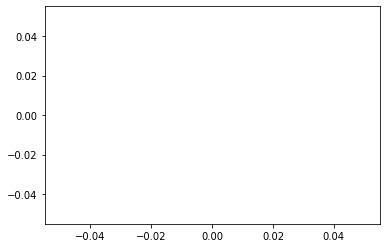

In [41]:
recording = rec
input_length, N_fft, N_single_sided = pad_array(recording)
y_l, y_r, X_f, Yl_f, Yr_f = transform_t_to_f(audio, recording, N_fft)
Hl_f, Hr_f = compute_filter(X_f, Yl_f, Yr_f)
hl, hr = transform_f_to_t(Hl_f, Hr_f, N_fft, input_length)
sweep_stereo = make_sweep_stereo(y_l, y_r)
impulse_response = create_impulse_response(hl, hr)


f_vec = np.linspace(0, fs/2, int(N_single_sided))
# mp.semilogx(f_vec, 20*np.log10(np.abs(Hr_f)))

print(np.shape(impulse_response))

mp.plot(impulse_response[:, 1])

write_impulse_response(impulse_response, fs, headphone, i)

In [ ]:
# define length of FFT (zero padding): at least double length of input
# input_length = np.size(sweep_rec)
# n = np.ceil(np.log2(input_length)) + 1
# N_fft = int(pow(2, n))
# N_single_sided = N_fft/2+1

In [ ]:
# transform 
# real fft: N real input -> N/2+1 complex output (single sided spectrum)
# real ifft: N/2+1 complex input -> N real output
# y_l = sweep_rec[:, 0] #/  32768.0
# y_r = sweep_rec[:, 1] #/  32768.0
# 
# X_f = rfft(sweep, N_fft)
# Yl_f = rfft(y_l, N_fft)
# Yr_f = rfft(y_r, N_fft)

In [ ]:
t, tfs = convert_audio_to_numpy_array("../sounds/sweeps/beats_detox_sweep_0.wav")
# play audio
sd.play(t, tfs)

In [ ]:
# plot imported signals 
fig, (ax1, ax2, ax3) = mp.subplots(1, 3, figsize=(15, 2))

ax1.set_title('Excitation Sweep')
ax1.set_ylabel("Frequency [Hz]")
ax1.set_xlabel("Time [s]")
ax2.set_title('Recorded Sweep Left Ear')
ax2.set_xlabel("Time [s]")
ax3.set_title('Recorded Sweep Right Ear')
ax3.set_xlabel("Time [s]")

v_min = -120
v_max = -50

_, _, _, cax1 = ax1.specgram(sweep+0.000001, NFFT=512, Fs=fs, noverlap=300, vmin=v_min, vmax=v_max)
_, _, _, cax2 = ax2.specgram(y_l, NFFT=512, Fs=fs, noverlap=300, vmin=v_min, vmax=v_max);
_, _, _, cax3 = ax3.specgram(y_r, NFFT=512, Fs=fs, noverlap=300, vmin=v_min, vmax=v_max);

fig.colorbar(cax3, ax=ax3).set_label('Intensity [dB]')

In [ ]:
# plot
# f_vec = np.linspace(0, sweep_fs/2, int(N_single_sided))
# fig, (ax1, ax2, ax3) = mp.subplots(1, 3, figsize=(15, 2), sharex=True)
# ax1.set_title('Excitation')
# ax1.set_xlabel("Frequency [Hz]")
# ax1.set_ylabel("Magnitude [dB]")
# 
# ax2.set_title('Recorded Left')
# ax2.set_xlabel("Frequency [Hz]")
# 
# ax3.set_title('Recorded Right')
# ax3.set_xlabel("Frequency [Hz]")
# 
# ax1.semilogx(f_vec, 20*np.log10(np.abs(X_f)))
# ax2.semilogx(f_vec, 20*np.log10(np.abs(Yl_f)))
# ax3.semilogx(f_vec, 20*np.log10(np.abs(Yr_f)))
# 
# ax1.set_xlim([20, sweep_fs/2]);
#ax1.set_ylim([100, 150]);

In [ ]:
#X_f_inv = 1 / X_f
#Hl_f = Yl_f * X_f_inv
#Hr_f = Yr_f * X_f_inv
#
## plot
#fig, (ax1, ax2) = mp.subplots(1, 2, figsize=(15, 2), sharex=True, sharey=True)
#ax1.set_title('HRTF L')
#ax1.set_xlabel("Frequency [Hz]")
#ax1.set_ylabel("Magnitude [dB]")
#
#ax2.set_title('HRTF R')
#ax2.set_xlabel("Frequency [Hz]")
#
#ax1.semilogx(f_vec, 20*np.log10(np.abs(Hl_f)))
#ax2.semilogx(f_vec, 20*np.log10(np.abs(Hr_f)))
#
#ax1.set_xlim([20, sweep_fs/2]);
#ax1.set_ylim([-70, 20]);

In [ ]:
# backward transform
# hl = irfft(Hl_f, N_fft)
# hr = irfft(Hr_f, N_fft)

In [ ]:
# truncate to original length
# hl = hl[:int(input_length/2)]
# hr = hr[:int(input_length/2)]

In [ ]:
# t_vec = np.arange(0, np.size(hl)) / fs
# fig, ((ax1, ax2), (ax3, ax4)) = mp.subplots(2, 2, figsize=(15, 8), sharex='row', sharey='row')
# 
# ax1.plot(t_vec, 20*np.log10(np.abs(hl)))
# ax1.set_title("IR Left Logarithmic")
# ax1.set_ylim([-120, 12])
# ax1.set_ylabel("Magnitude [dB]")
# 
# ax2.plot(t_vec, 20*np.log10(np.abs(hr)))
# ax2.set_title("IR Right Logarithmic")
# ax2.set_ylim([-120, 12])
# 
# ax3.plot(t_vec, hl)
# ax3.set_title("IR Left (zoomed in)")
# ax3.set_xlabel('Seconds');
# ax3.set_ylabel("Amplitude")
# 
# ax4.plot(t_vec, hr)
# ax4.set_title("IR Right (zoomed in)")
# ax4.set_xlabel('Seconds');
# 
# 
# ax3.set_xlim([0.257, 0.27])

In [ ]:
# convert sweep wav file into ndarray
t, tfs = convert_audio_to_numpy_array("../sounds/sweeps/beyer_dynamic_dt_990_pro_old_sweep_0.wav")
# play audio
sd.play(t, tfs)

In [ ]:
print(sweep_stereo.dtype)
print(impulse_response.dtype)
